<a href="https://colab.research.google.com/github/rohbot25/Erohan_Repository/blob/main/simulationTester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install taichi==1.1.2

In [ ]:
import taichi as ti
import numpy as np
import os
import math

max_steps = 100
dt = 0.001
learning_rate = 0.0001
gravity = -9.8
soil_damping = .99 # add soil damping / spring damping
damping = 1
stiffness = 1000.0
ground_height = 0.0
sim_size = 512
epsilon = 0.00001

scale = 0.75
soil_particles = 24

real = ti.f32

startingObjectPositions = []

object_radius = 51
object_mass = 51

object_loc = [2,4]

soil = []
mass = []

radius = 51 / 512
for i in range(5):
  for j in range(5):
    if(i == object_loc[0] and j == object_loc[1]):
      startingObjectPositions.append([(2 * i + 1)  * radius + .0001, (2 * j + 1) * radius + .001])
    else:
      soil.append([(2 * i + 1)  * radius + .0001, (2 * j + 1) * radius  + .001])
      mass.append(51)

n_soils = len(soil)

n_objects = len(startingObjectPositions)
#for i in range(soil_particles):
  #soil.append([np.random.uniform(),np.random.uniform()* 0.5 + 0.1001])
  #mass.append(50)

ti.init( default_fp = real )

vec = lambda: ti.Vector.field(2, dtype = real)

soilPositions = vec()
soilVelocities = vec()
masses = ti.field(ti.i32)

positions = vec()
velocities = vec()

object_normal_velocities = ti.field(ti.f32)
soil_normal_velocities = ti.field(ti.f32)


# ------------------------------------------

ti.root.dense(ti.i, max_steps).dense(ti.j, n_objects).place(positions)
ti.root.dense(ti.i, max_steps).dense(ti.j, n_objects).place(positions.grad)
ti.root.dense(ti.i, max_steps).dense(ti.j, n_objects).place(velocities)

ti.root.dense(ti.i, max_steps).dense(ti.j, soil_particles).place(object_normal_velocities)
ti.root.dense(ti.i, max_steps).dense(ti.j, soil_particles).place(soil_normal_velocities)

ti.root.dense(ti.i, max_steps).dense(ti.j, soil_particles).place(soilPositions)
ti.root.dense(ti.i, max_steps).dense(ti.j, soil_particles).place(soilVelocities)
ti.root.dense(ti.i, soil_particles).place(masses)

# ------------------------------------------

def Draw(frameOffset):
  for timeStep in range(0,max_steps):

    gui = ti.GUI("Robot" , (sim_size,sim_size), background_color = 0xFFFFFF, show_gui=False)

    #draw the floor
    gui.line( begin = ( 0, ground_height) ,
              end = (1,ground_height) ,
              color = 0x0,
              radius = 1)
    gui.line( begin = (0,0) ,
              end = (0,1) ,
              color = 0x0,
              radius = 1)
    gui.line( begin = (1,0) ,
              end = (1,1) ,
              color = 0x0,
              radius = 1)
    #draw the soil
    for particle in range(soil_particles):
      x = soilPositions[timeStep,particle][0]
      y = soilPositions[timeStep,particle][1]
      gui.circle ( (x,y), color = 0x0 , radius = masses[particle] )
    #draw objects
    for objectIndex in range(n_objects):

      x = positions[timeStep,objectIndex][0]
      y = positions[timeStep,objectIndex][1]

      gui.circle ( (x,y), color = 0xFF0000 , radius = object_radius )

    gui.show( 'test' + str(frameOffset + timeStep) + '.png')

# ----------------------------------------

def Initialize():

  os.system("rm test*.png")

  for i in range(1,max_steps):
    for j in range(n_objects):
      velocities[i,j] = [0,0]
      positions[i,j] = [0,0]

  for i in range(1,max_steps):
    for j in range(soil_particles):
      object_normal_velocities[i,j] = 0
      soilPositions[i,j] = [0,0]
      soilVelocities[i,j] = [0,0]

  for objectIndex in range(n_soils):

    soilPositions[0,objectIndex] = soil[objectIndex]

    soilVelocities[0,objectIndex] = [0.0,0.0]

    masses[objectIndex] = mass[objectIndex]

    object_normal_velocities[0,objectIndex] = 0

  for objectIndex in range(n_objects):
      positions[0,objectIndex] = startingObjectPositions[objectIndex]
      velocities[0,objectIndex] = [0,0]



# ----------------------------------------

def Simulate(force):

  for timeStep in range(1,max_steps):
    Simulate_Soil(timeStep)
    Simulate_Objects(timeStep,force)

#----------------------------------------

#@ti.kernel
@ti.ad.no_grad
def Simulate_Soil(timeStep: ti.i32):
  #for each soil particle
    for objA in range(soil_particles):

      velocityA = soilVelocities[timeStep-1,objA]

      collision = False
      #get next particle
      for objB in range(soil_particles):

        velocityB = soilVelocities[timeStep-1,objB]

        #if its not the same particle
        if (objB is not objA):
          #find distance between them
          posA = soilPositions[timeStep-1,objA]
          posB = soilPositions[timeStep-1,objB]
          dist = posA - posB
          length = dist.norm()

          #find the sum of radii
          radiusA = masses[objA] / sim_size
          radiusB = masses[objB] / sim_size
          radiiSum = radiusA + radiusB
          #if the distance betweeen them is less than the sum aka they are in collision
          if (length < radiiSum):
            collision = True
            #if they are directly on top of eachother, pretend like they are nearly on top - discrete timestep issue
            if length < epsilon:
              length = epsilon
            #find the unit normal and tangent of the collision
            normal = dist / length
            tangent = ti.Vector([-normal[1], normal[0]])
            #find the scalar of the collision
            soil_A_Unit_Norm = ti.Vector.dot(velocityA, normal)
            soil_A_Unit_Tan = ti.Vector.dot(velocityA, tangent)
            soil_B_Unit_Norm = ti.Vector.dot(velocityB, normal)
            soil_B_Unit_Tan = ti.Vector.dot(velocityB, tangent)
            #do the collision - scalar
            soil_A_New_Norm = (soil_A_Unit_Norm * (masses[objA] - masses[objB]) + 2 * masses[objB] * soil_B_Unit_Norm) / (masses[objA] + masses[objB])
            soil_B_New_Norm = (soil_B_Unit_Norm * (masses[objB] - masses[objA]) + 2 * masses[objA] * soil_A_Unit_Norm) / (masses[objA] + masses[objB])
            #vectorize them in the unit normal and tangential direction
            vec_A_Norm = soil_A_New_Norm * normal
            vec_A_Tan = soil_A_Unit_Tan * tangent
            vec_B_Norm = soil_B_New_Norm * normal
            vec_B_Tan = soil_B_Unit_Tan * tangent
            #add together and update the soil + damping
            velocityA = (vec_A_Norm + vec_A_Tan)
            velocityB = (vec_B_Norm + vec_B_Tan)
            #get them out of collision
            overlap = (radiiSum - length) / 2
            soilPositions[timeStep, objA] = soilPositions[timeStep-1,objA] + overlap * normal
            soilPositions[timeStep, objB] = soilPositions[timeStep-1,objB] - overlap * normal

            while length < radiiSum:
              soilPositions[timeStep, objA] += overlap * normal
              soilPositions[timeStep, objB] -= overlap * normal
              length += overlap * 2

            soilVelocities[timeStep,objB] = velocityB * (1-soil_damping) + dt * gravity * ti.Vector([0,1])
            soilVelocities[timeStep,objA] = velocityA * (1-soil_damping) + dt * gravity * ti.Vector([0,1])

      #if they are out of bounds update accordingly
      particle_radius = masses[objA] / sim_size
      if not collision:
        currentPosition = soilPositions[timeStep-1,objA]
        currentVelocity = soilVelocities[timeStep-1,objA] * (1-soil_damping)
      else:
        currentPosition = soilPositions[timeStep,objA]
        currentVelocity = soilVelocities[timeStep,objA]

      if currentPosition[0] > 1 - particle_radius:
            currentPosition[0] = 1 - particle_radius
            currentPosition[0] *= -1

      if currentPosition[0] < particle_radius:
            currentPosition[0] = particle_radius
            currentPosition[0] *= -1

      if currentPosition[1] < ground_height + particle_radius:
            currentPosition[1] = ground_height + particle_radius
            currentPosition[1] *= -1
      #if no collisions occured, just leave the updated velocities?
      #TODO this order makes no sense

      soilVelocities[timeStep,objA] = currentVelocity
      soilPositions[timeStep,objA] = currentPosition + dt * soilVelocities[timeStep,objA]




@ti.kernel
def Simulate_Objects(timeStep: ti.i32, force : ti.i32):

 #for each part of the robot - in this case 1
  for robot in range(n_objects):

    #get velocity and position
    velocity = velocities[timeStep-1,robot]
    position = positions[timeStep-1,robot]


    #for each soil particle
    for soil in range(soil_particles):
      #collision between robot - soil particles
      #get distance between robot and soil
      posB = position
      posA = soilPositions[timeStep-1,soil]
      dist = posA - posB
      length = dist.norm()

      #find the sum of the two radii
      radiusA = masses[soil] / sim_size
      radiusB = object_radius / sim_size
      radiiSum = radiusA + radiusB
      #if the objects are closer than the two radii, then they are in collision
      if (length < radiiSum):
        #if they are directly on top of eachother, pretend like they are nearly on top - discrete timestep issue
        if length < epsilon:
          length = epsilon

        #find the unit normal and tangent of the collision
        normal = dist / length
        tangent = ti.Vector([-normal[1], normal[0]])

        obj_unit_norm = ti.Vector.dot(velocity, normal)
        obj_unit_tan = ti.Vector.dot(velocity, tangent)
        soil_unit_norm = ti.Vector.dot(soilVelocities[timeStep-1,soil], normal)
        soil_unit_tan = ti.Vector.dot(soilVelocities[timeStep-1,soil], tangent)

        #do the collision - scalar
        soil_new_norm = (soil_unit_norm * (masses[soil] - object_mass) + 2 * object_radius * obj_unit_norm) / (masses[soil] + object_mass)
        obj_new_norm = (obj_unit_norm * (object_mass - masses[soil]) + 2 * masses[soil] * soil_unit_norm) / (masses[soil] + object_mass)

        #vectorize them in the unit normal and tangential direction
        vec_soil_norm = soil_new_norm * normal
        vec_soil_tan = soil_unit_tan * tangent
        vec_obj_norm = obj_new_norm * normal
        vec_obj_tan = obj_unit_tan * tangent

        #add together and update the soil + damping
        soilVelocities[timeStep,soil] = (vec_soil_norm + vec_soil_tan) * (1-soil_damping) + dt * gravity * ti.Vector([0,1])
        #new velocity
        velocity = (vec_obj_norm + vec_obj_tan)
        #get them out of collision
        overlap = (radiiSum - length) / 2
        soilPositions[timeStep,soil] = soilPositions[timeStep-1,soil] + overlap * normal
        position = positions[timeStep-1,robot] - overlap * normal

        while length < radiiSum:
          soilPositions[timeStep,soil] += overlap * normal
          position -= overlap * normal
          length += overlap * 2

    #get the Position now out of collision
    currentPosition = position

    #new velocity - damp the velocity based on depth?
    newVelocity = (velocity + force * ti.Vector([0,1]) * dt + dt * gravity * ti.Vector([0,1])) * position[1]

    #new position
    newPosition = currentPosition + dt * newVelocity

    #make sure new position is not out of bounds
    if newPosition[1] < ground_height + object_radius/sim_size:
            newPosition[1] = ground_height + object_radius/sim_size
            newVelocity[1] *= -1


    #TODO look at the velocities

    #update the returned positions and velocities
    positions[timeStep,robot] = newPosition

    velocities[timeStep,robot] = newVelocity

# ----------------------------------------

def Step_One(timeStep: ti.i32):

  Simulate_Objects(timeStep)


# ----------------------------------------

def Make_Movie(frame_rate):
    os.system("rm movie.mp4")
    os.system(f"ffmpeg -r {frame_rate} -i test%d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p movie.mp4")


# ----------------------------------------

# ---------- Main body of code



#for timeStep in range(1,max_steps):
  #for soil in range(soil_particles):
    #print(f'soil: {soil}')
    #print(f'object_normal_velocities: {object_normal_velocities[timeStep,soil]}')
    #print(f'position: {positions[timeStep,0]}')
    #print(f'soilPos: {soilPositions[timeStep,soil]}')
    #dist = positions[timeStep,0] - soilPositions[timeStep,soil]
    #print(f'dist: {dist}')
    #length = dist.norm()
    #print(f'length: {length}')
    #print(f'radiiSum: {masses[soil]/sim_size + object_radius/sim_size}')

#for timeStep in range(1,max_steps):
  #print(f'velocities: {velocities[timeStep,0]}')
f = open('layer4.txt', 'w')

for i in range(1):
  Initialize()
  print(f'force: {i}')
  Simulate(-50)

  obj_forces = []
  resistances = []

  for timeStep in range(1,max_steps):
    for particle in range(n_soils):
      obj_forces.append((object_normal_velocities[timeStep,particle] - object_normal_velocities[timeStep-1,particle]) * object_mass / dt)
      if(obj_forces[-1] < 0):
        resistances.append(obj_forces[-1] * -1)


  print(f"Force: {sum(obj_forces)}")
  print(f"Resistance: {sum(resistances)}")
  f.write(f"{sum(obj_forces)}\n")
  print(obj_forces)
f.close()
Draw(0)
Make_Movie(75)
#watch movie
from IPython.display import HTML
from base64 import b64encode
mp4 = open('movie.mp4', 'rb').read()
data_url = "data:video/mp4;base64,"+ b64encode(mp4).decode()

HTML('<video width=sim_size controls> <source src="%s" type="video/mp4"></video>' % data_url)



[Taichi] Starting on arch=x64
force: 0
Force: 0.0
Resistance: 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with open('layer0.txt') as f:
    layer0 = f.readlines()
with open('layer1.txt') as f:
    layer1 = f.readlines()
with open('layer2.txt') as f:
    layer2 = f.readlines()
with open('layer3.txt') as f:
    layer3 = f.readlines()
with open('layer4.txt') as f:
    layer4 = f.readlines()

layer0 = [float(i) for i in layer0]
layer1 = [float(i) for i in layer1]
layer2 = [float(i) for i in layer2]
layer3 = [float(i) for i in layer3]
layer4 = [float(i) for i in layer4]

plt.plot(layer0, label = 'layer 0')
plt.plot(layer1, label = 'layer 1')
plt.plot(layer2, label = 'layer 2')
plt.plot(layer3, label = 'layer 3')
plt.plot(layer4, label = 'layer 4')

plt.title('Force vs Resistance')
plt.xlabel('Exerted Force')
plt.ylabel('Resistance')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'layer0.txt'

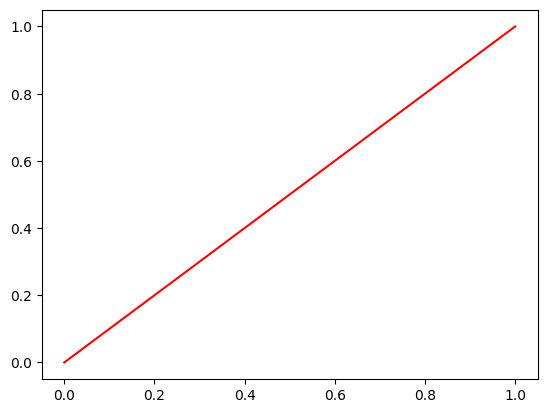

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(1,0,10)
plt.plot(x, x, color = 'red')
plt.show()